In [1]:
!pip3 install mnist
!pip3 install minisom

# imports
import matplotlib.pyplot as plt
import numpy as np
import mnist
import scipy.misc
import math
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib import cm

from sklearn import datasets,metrics
from sklearn.datasets import fetch_20newsgroups, fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
import umap
from minisom import MiniSom
from sklearn.feature_extraction import text

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans

from sklearn.metrics.pairwise import euclidean_distances

from joblib import Parallel, delayed
from tqdm import tqdm

!pip install ipython-autotime
%load_ext autotime

/home/adalmia1/anaconda3/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


time: 939 µs (started: 2021-02-09 08:11:46 -05:00)


In [2]:
phrases_id = []
text_sent = []
label = []

datapath = 'data/stanfordSentimentTreebank/dictionary.txt'
labelpath = 'data/stanfordSentimentTreebank/sentiment_labels.txt'

#print(text.ENGLISH_STOP_WORDS)
with open(datapath, 'r', encoding="utf8", errors='ignore') as infile:
  for line in infile:
    intext = line.replace('\n','')
    intext = intext.split("|")
    phrase = intext[0].split()
    new_phrase = []
    
    for p in phrase:
      if (p.lower() not in text.ENGLISH_STOP_WORDS):
        if str.isdigit(p):
          new_phrase.append("N")
        else:
          new_phrase.append(p.lower())
        
    if(len(new_phrase) >= 5):
      new_phrase = " ".join(new_phrase)
      phrases_id.append(int(intext[1]))
      text_sent.append(new_phrase)

text_sent = np.array(text_sent)
with open(labelpath, 'r', encoding="utf8", errors='ignore') as infile:
  for line in infile:
    sentiment = line.replace('\n','')
    sentiment_val = float(sentiment.split("|")[1])
    if sentiment_val < 0.2:
      label.append(0)
    elif sentiment_val >= 0.4 and sentiment_val < 0.6:
      label.append(1)
    elif sentiment_val >= 0.8 and sentiment_val < 1 :
      label.append(2)
    else:
      label.append(-1)

label = np.array(label)
label  = label[phrases_id]

np.random.seed(0)
net = np.where(label==1)[0]
to_keep = np.random.choice(len(np.where(label==1)[0]), 8000, replace=False)
net_to_keep = set(net[to_keep])
net_remove = list(set(net) - net_to_keep)
label[net_remove] = -1  


valid = np.where(label != -1)[0].astype(int)

text_sent = text_sent[valid]
label = label[valid]   
      
print(label.shape)      
print(label.shape)      
vectorizer = TfidfVectorizer(min_df=5, token_pattern='\S+', stop_words='english')


ss_X = vectorizer.fit_transform(text_sent)
ss_y = label

print(ss_X.shape)
      
      
                            

(23762,)
(23762,)
(23762, 7129)
time: 2.92 s (started: 2021-02-09 08:11:46 -05:00)


In [3]:
# k-Means clustering
def kmeans(X_train, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, n_jobs = 1, random_state=2)
  y_pred_train = kmeans.fit_predict(X_train)
  train_centers = kmeans.cluster_centers_

  return y_pred_train
  

time: 502 µs (started: 2021-02-09 08:11:49 -05:00)


In [4]:
# Spectral clustering 
def spectral(X_train, n_clusters):
  #med = np.median(euclidean_distances(X_train)) gamma=2*(1/med)**2,
  spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
  y_pred_train = spectral.fit_predict(X_train)

  return y_pred_train


time: 37.2 ms (started: 2021-02-09 08:11:49 -05:00)


In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Evaluation function
def evaluate(X, y, y_pred):
    print("Accurary Score: %0.3f" % purity_score(y, y_pred))
    print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))
    #print(np.unique(y_pred))
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, sample_size=1000))
    print()



time: 31.2 ms (started: 2021-02-09 08:11:49 -05:00)


In [ ]:
# dimension reduction
#import dill as pickle


def umap_reduce(X_train, dim):
  umapr = umap.UMAP(n_components=dim, n_neighbors=25, n_epochs = 800, n_jobs=1)
  X_train_umap = umapr.fit_transform(X_train)
  #X_test_umap = umapr.fit_transform(X_test)
  return X_train_umap #, X_test_umap




def cv_score(estimator, g, X, y, n_clusters):
  estimator.set_params(**g)
  X_r = estimator.fit_transform(X)
  y_pred = kmeans(X_r, n_clusters)
  return (purity_score(y, y_pred), g)
  



def dimension_reduce(dimensions, X, y, n_clusters):
  y_pred_train = kmeans(X, n_clusters)
  print("Original KMeans")
  evaluate(X,y,y_pred_train) 

  #y_pred_train = spectral(X, n_clusters)
  #print("Original Spectral")
  #evaluate(X ,y,y_pred_train)
  
  
  param_grid = [{
        "n_neighbors": [15, 25],
        "metric": ['euclidean'],
        "min_dist": np.linspace(0.1, 1, 5)
    }]
  
  param_grid = ParameterGrid(param_grid)
  
  
  for dim in dimensions:
    
    umapr = umap.UMAP(n_components=dim, disconnection_distance = np.inf, n_jobs=1, n_epochs = 500)
    print("Reduce")
    #results = np.array(Parallel(n_jobs=1)(delayed(cv_score)(umapr, g, X, y, n_clusters)  for g in tqdm(param_grid))) 
    results = []
    for g in tqdm(param_grid):
      results.append(cv_score(umapr, g, X, y, n_clusters))
    
    best_param = sorted(results, key=lambda t: t[0], reverse=True)[:1]
    best_param = best_param[0][1] 
    print(best_param)
    umapr.set_params(**best_param)
    X_umap = umapr.fit_transform(X)
    
    y_pred_train = kmeans(X_umap,  n_clusters)
    print("KMeans dimension reduce: " + str(dim))
    evaluate(X_umap,y,y_pred_train)

    #y_pred_train = spectral(X_umap, n_clusters)
    #print("Spectral dimension reduce: " + str(dim))
    #evaluate(X_umap,y,y_pred_train)




dimension_reduce([7500], ss_X , ss_y, 3)


/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
  0%|          | 0/10 [00:00<?, ?it/s]

Original KMeans
Accurary Score: 0.379
Adjusted Mutual Information Score: 0.005
Adjusted Rand Index Score: 0.003
Normalized Mutual Information Score: 0.005
Homogeneity: 0.004
Completeness: 0.006
V-measure: 0.005
Silhouette Coefficient: 0.005

Reduce


/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


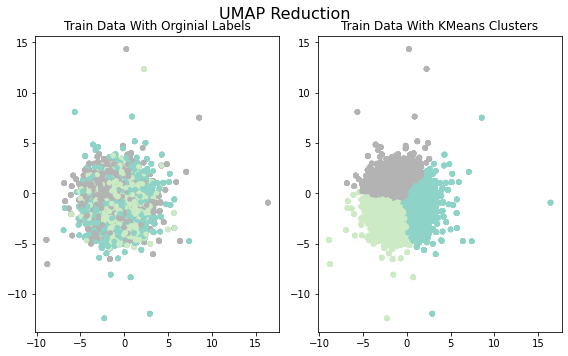

time: 2min 45s (started: 2021-02-09 08:20:50 -05:00)


In [13]:
def visualize(X_train, y_train, reduce, title, n_clusters):
 
  colors = []
  colors += cm.get_cmap("Set3").colors
  colors += cm.get_cmap("Set2").colors
  my_cmap = ListedColormap(colors)
  
  X_train_r = reduce(X_train, 2)
 

  kmy_pred_train = kmeans(X_train_r, n_clusters)
  #spy_pred_train, spy_pred_test = spectral(X_train_r, X_test_r, y_train, y_test, n_clusters)

  
  fig=plt.figure(figsize=(8,5))
  # Train orginial labels
  plt.subplot(1, 2, 1)
  plt.gca().set_title('Train Data With Orginial Labels')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= y_train, s=20, cmap=my_cmap)

  # Train kmeans labels
  plt.subplot(1, 2, 2)
  plt.gca().set_title('Train Data With KMeans Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= kmy_pred_train, s=20, cmap=my_cmap)
  #plt.scatter(train_centers [:, 0], train_centers [:, 1], c='black', s=100, alpha=0.8)


  fig.suptitle(title + " Reduction", fontsize=16)

  fig.tight_layout()
  fig.subplots_adjust(top=0.90)
  plt.show()



visualize(ss_X , ss_y, umap_reduce, "UMAP", 3)

In [ ]:
# Digits reduction 
#dimension_reduce([48, 32, 16, 8, 4, 2], digits_X_train, digits_X_test, digits_y_train, digits_y_test, kernel_pcarbf_reduce, 10)
#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, som_reduce, "SOM", 10)

#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, tsne_reduce, "TSNE", 10)

In [ ]:
# fetch 20 reduction 
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20)

#PCA
#visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, pca_reduce, "PCA", 20)

In [ ]:
dimension_reduce([7500, 5000, 2500, 1000, 500, 250, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, 20)

In [ ]:
dimension_reduce([7500, 5000, 2500, 1000, 500, 250, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, pca_reduce, 20)

In [ ]:
# rcv1 reduction
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
#visualize_pca(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
#visualize_tsne(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103, True)